# Deep Neural Network with Tensorflow (Biochemical Remission)

This notebook implements a deep neural network model using TensorFlow to predict fatigue in IBD patients. Key components include:

- Data preprocessing and feature optimization for production deployment
- Train/validation/test split with GroupShuffleSplit to prevent data leakage
- Standardization of numerical features
- DNN architecture with 2 hidden layers (324 and 100 units) and dropout regularization
- Model training with early stopping based on validation loss
- Comprehensive evaluation metrics (accuracy, sensitivity, specificity, AUC, R2)
- SHAP analysis for model interpretability including:
  - Summary plots showing feature importance
  - Force plots for analyzing individual predictions
- Export functionality for production deployment including:
  - Trained model
  - Feature scaler
  - SHAP explainer
  - Evaluation metrics and plots

The model can be run on either the full IBD cohort or biochemical remission subset by setting `run_biochem_remission`.

In [1]:
import pandas as pd
import numpy as np
import shap
import json
import pickle
from joblib import dump
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import datetime
from tensorflow.keras.metrics import AUC

from src.data.preprocessing import (
    load_and_preprocess_data,
    fix_numerical_features_for_production,
    remove_low_value_features,
)
from src.data.splitting import split_data_for_keras
from src.config.constants import NUMERICAL_FEATURES, RANDOM_SEED
from src.config.paths import DNN_DIR, DNN_BIOCHEM_REMISSION_DIR, ensure_output_dirs
from src.visualization.plotting import (
    plot_training_validation_auc,
    plot_training_validation_loss,
    plot_roc_curve,
    plot_confusion_matrix,
)

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ensure_output_dirs()

## Pipeline Configuration & Data Loading

In [3]:
random_seed = RANDOM_SEED  # Random seed to ensure reproducibility
run_biochem_remission = True  # Whether to use the biochem remission cohort
keras.utils.set_random_seed(random_seed)  # Set random seed for Keras

if run_biochem_remission:
    output_path = DNN_BIOCHEM_REMISSION_DIR
    cmap = "berlin"
    df = load_and_preprocess_data(biochemical_remission=True)
else:
    output_path = DNN_DIR
    cmap = "seismic"
    df = load_and_preprocess_data()

## Optimise Features for Production

In [4]:
# We removed low value features here and simplified the model
df = remove_low_value_features(df)
numerical_features = NUMERICAL_FEATURES
numerical_features = fix_numerical_features_for_production(numerical_features)

## Split Data into Train, Validation and Test Sets

In [5]:
X_train, X_val, X_test, y_train, y_val, y_test, groups = split_data_for_keras(df)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)
print("Y train shape:", y_train.shape)
print("Y val shape:", y_val.shape)
print("Y test shape:", y_test.shape)

Train shape: (178, 65)
Val shape: (41, 65)
Test shape: (48, 65)
Y train shape: (178,)
Y val shape: (41,)
Y test shape: (48,)


## Scale Numerical Features

In [6]:
X_unified = pd.concat([X_train, X_val, X_test])
unified_scaler = StandardScaler()
unified_scaler.fit(X_unified[numerical_features])

X_train[numerical_features] = unified_scaler.transform(X_train[numerical_features])
X_test[numerical_features] = unified_scaler.transform(X_test[numerical_features])
X_val[numerical_features] = unified_scaler.transform(X_val[numerical_features])

## DNN Model Building


### Model Definition

In [7]:
model = keras.Sequential(
    [
        layers.Dense(324, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(100, activation="relu"),
        layers.Dropout(0.4),
        layers.Dense(1, activation="sigmoid"),
    ]
)

# log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

### Compile the Model

In [8]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.0002)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[AUC()])

In [9]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_callback],
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - auc: 0.4932 - loss: 0.6703 - val_auc: 0.6210 - val_loss: 0.5958
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc: 0.5961 - loss: 0.6204 - val_auc: 0.6871 - val_loss: 0.5632
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc: 0.6383 - loss: 0.6058 - val_auc: 0.7613 - val_loss: 0.5427
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.6475 - loss: 0.6019 - val_auc: 0.8210 - val_loss: 0.5288
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.5665 - loss: 0.6219 - val_auc: 0.8452 - val_loss: 0.5182
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.6708 - loss: 0.5907 - val_auc: 0.8452 - val_loss: 0.5096
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.7360 - loss: 0.5729 - val_auc: 0.8452 - val_loss: 0.5025
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.7506 - loss: 0.5667 - val_auc: 0.8694 - val_loss: 0.4958
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.7622 - loss: 0.5562 -

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 324)            │        21,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 324)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        32,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,972 (421.77 KB)

 Trainable params: 53,985 (210.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 53,987 (210.89 KB)

In [11]:
history_dict = history.history
history_dict.keys()

dict_keys(['auc', 'loss', 'val_auc', 'val_loss'])

### Training Plots

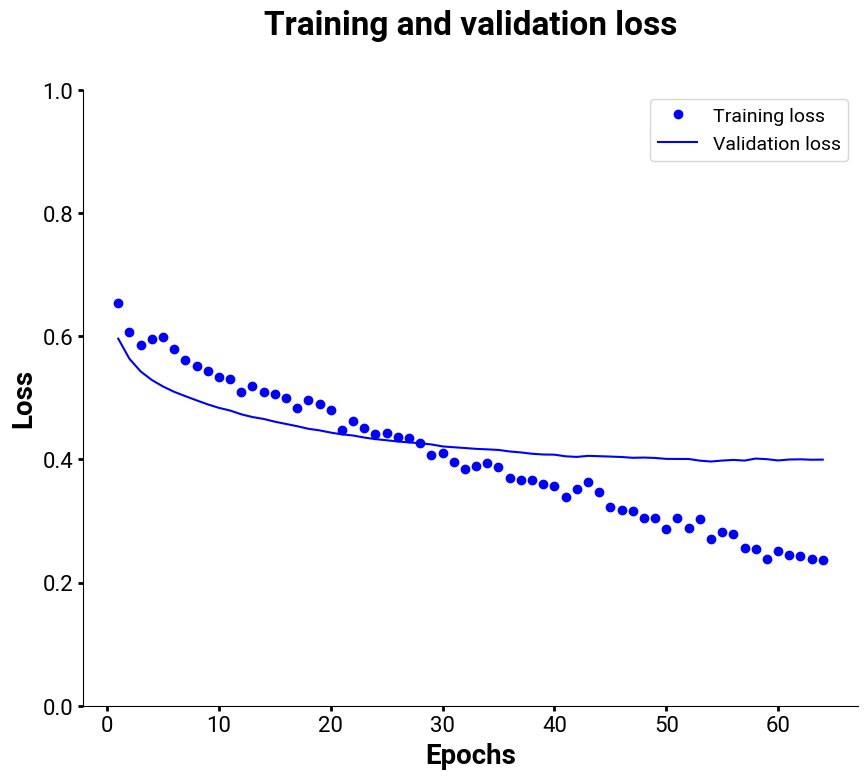

In [12]:
save_path = output_path / "plots" / "training_validation_loss.png"
plot_training_validation_loss(history_dict, save_path)

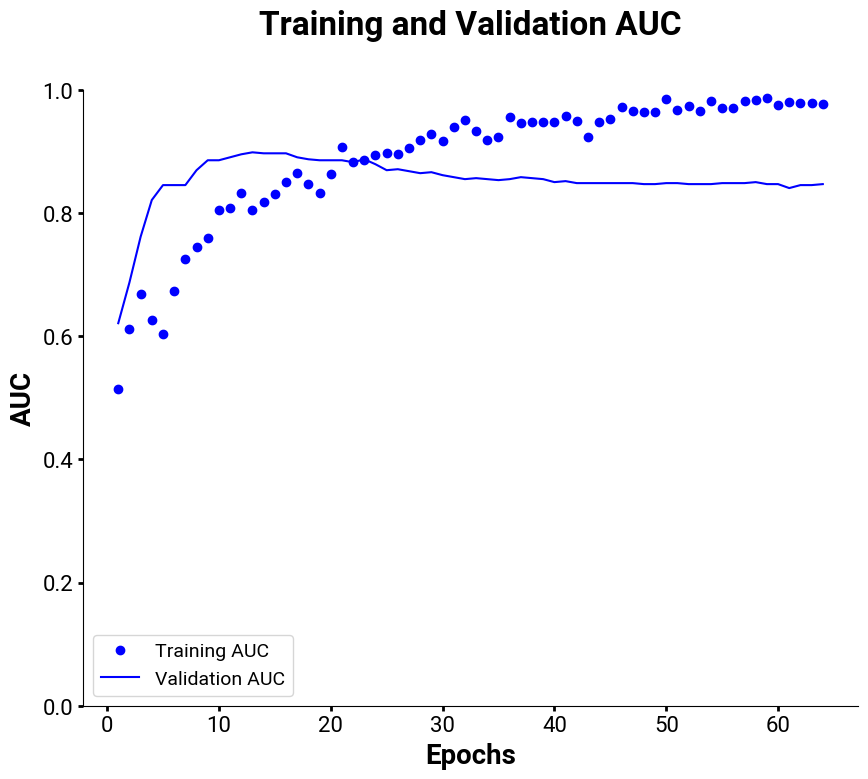

In [13]:
save_path = output_path / "plots" / "training_validation_auc.png"
plot_training_validation_auc(history_dict, save_path)

## Model Evaluation

In [14]:
results = model.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9320 - loss: 0.3356


### Metrics

In [15]:
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    accuracy_score,
    recall_score,
    r2_score,
)

y_pred = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred)

y_classes = np.where(y_pred > 0.5, 1, 0)

tn, fp, fn, tp = confusion_matrix(y_test, y_classes).ravel()

# Calculate metrics
accuracy = accuracy_score(y_test, y_classes)
sensitivity = recall_score(y_test, y_classes)  # TPR
specificity = tn / (tn + fp)  # TN

r2 = r2_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("AUC:", test_auc)
print("R2:", r2)

metrics_dictionary = {
    "accuracy": accuracy,
    "sensitivity": sensitivity,
    "specificity": specificity,
    "auc": test_auc,
    "r2": r2,
}

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Accuracy: 0.9375
Sensitivity: 0.75
Specificity: 1.0
AUC: 0.9143518518518519
R2: 0.4938102960586548


### Confusion Matrix

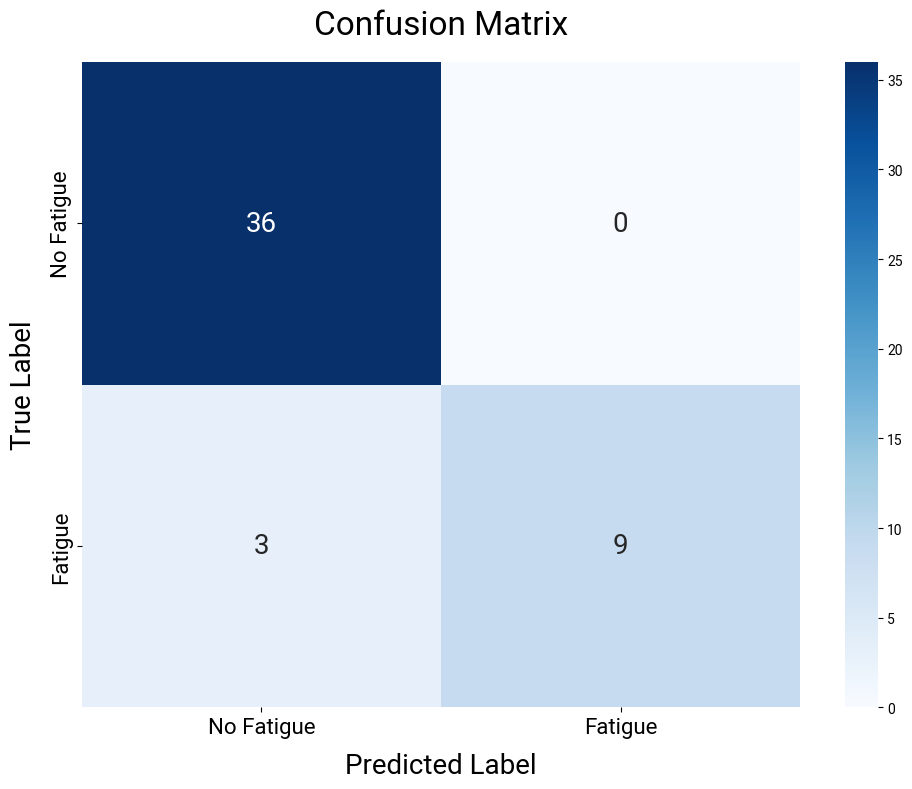

In [16]:
save_path = output_path / "plots" / "confusion_matrix.png"
plot_confusion_matrix(y_test, y_classes, save_path)

### ROC Curve

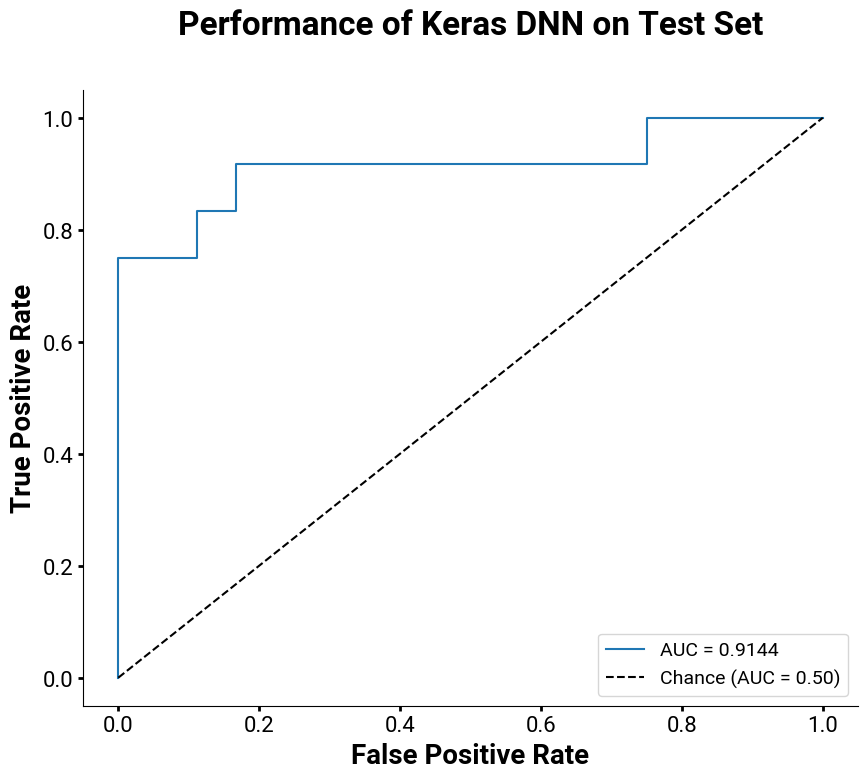

In [17]:
save_path = output_path / "plots" / "roc_curve.png"
plot_roc_curve(fpr, tpr, test_auc, save_path)

### Export Metrics

In [18]:
save_path = output_path / "metrics" / "dnn_metrics.json"
with open(save_path, "w") as f:
    json.dump(metrics_dictionary, f)

np.savetxt(output_path / "metrics" / "dnn_fpr.txt", fpr)
np.savetxt(output_path / "metrics" / "dnn_tpr.txt", tpr)

ssaml_df = pd.concat([y_test, pd.DataFrame(y_pred)])
ssaml_df.to_csv(
    output_path / "exports" / "ssaml_export.csv", index=True
)  # for SSAML sample size analysis

## SHAP Analysis

In [19]:
# Clean Column Names for Graphs

X_test_clean_columns = [
    col.replace("montreal_cd_location_", " ") for col in X_test.columns
]
X_test_clean_columns = [col.replace("_", " ") for col in X_test_clean_columns]
X_test_clean_columns = [
    col.replace("montreal uc extent ", "") for col in X_test_clean_columns
]
X_test_clean_columns = [
    col.replace("montreal uc severity ", "") for col in X_test_clean_columns
]
X_test_clean_columns = [
    col.replace("montreal cd behaviour ", "") for col in X_test_clean_columns
]
X_test_clean_columns = [col.replace("is smoker ", "") for col in X_test_clean_columns]
X_test_clean_columns = [col.replace("name ", "") for col in X_test_clean_columns]
# to title case
X_test_clean_columns = [col.title() for col in X_test_clean_columns]
replacements = {
    "Uc": "UC",
    "Cd": "CD",
    "Ibdu": "IBDU",
    "Bmi": "BMI",
    "Crp": "CRP",
    "Gi": "GI",
}

for old, new in replacements.items():
    X_test_clean_columns = [col.replace(old, new) for col in X_test_clean_columns]
print(X_test_clean_columns)

['Age', 'Sex', 'Height', 'Weight', 'BMI', 'Age At Diagnosis', 'Montreal Upper GI', 'Montreal Perianal', 'Has Active Symptoms', 'Albumin', 'CRP', 'Haemoglobin', 'Red Cell Count', 'White Cell Count', 'Neutrophils', 'Lymphocytes', 'Monocytes', 'Eosinophils', 'Basophils', 'Platelets', 'Urea', 'Creatinine', 'Sodium', 'Potassium', 'Calprotectin', 'Sampling Steroids', 'Sampling Abx', 'Sampling Asa', 'Sampling Aza', 'Sampling Mp', 'Sampling Ifx', 'Sampling Ada', 'Sampling Vedo', 'Sampling Uste', 'Sampling Tofa', 'Sampling Mtx', 'Sampling Ciclosporin', 'Sampling Filgo', 'Sampling Upa', 'Sampling Risa', 'Disease Duration Weeks', 'Diagnosis Year', 'Study Group CD', 'Study Group IBDU', 'Study Group UC', ' L1 Ileal', ' L2 Colonic', ' L3 Ileocolonic', 'B1 Non-Stricturing, Non-Penetrating', 'B2 Stricturing', 'B3 Penetrating', 'E1 Proctitis', 'E2 Left-Sided', 'E3 Extensive', 'S0 Remission', 'S1 Mild', 'S2 Moderate', 'S3 Severe', 'Ex-Smoker', 'Non-Smoker', 'Smoker', 'Season Autumn', 'Season Spring', 'S

### Explainer and SHAP Values Computation

In [20]:
explainer = shap.KernelExplainer(
    model, shap.sample(X_train, 200, random_state=random_seed)
)
shap_values = explainer.shap_values(X_test)
shap_values_class_1 = shap_values[:, :, 0]  # collapses 3d array to 2d

Using 178 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 48/48 [00:32<00:00,  1.46it/s]


### Summary Plots

In [21]:
shap.initjs()

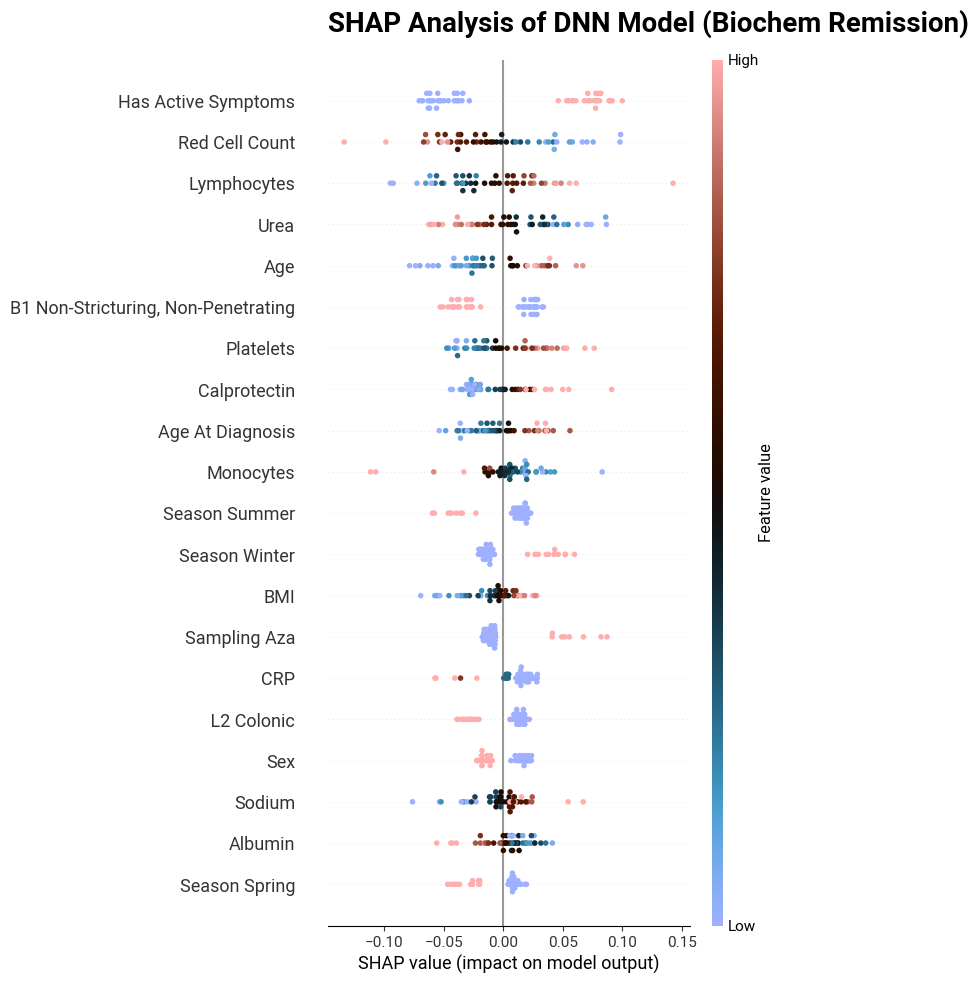

In [22]:
shap.summary_plot(
    shap_values_class_1,
    X_test,
    feature_names=X_test_clean_columns,
    show=False,
    cmap=cmap,
)
if run_biochem_remission:
    plt.title(
        "SHAP Analysis of DNN Model (Biochem Remission)",
        fontsize=20,
        pad=20,
        loc="left",
        fontweight="bold",
    )
else:
    plt.title(
        "SHAP Analysis of DNN Model (All IBD)",
        fontsize=20,
        pad=20,
        loc="left",
        fontweight="bold",
    )

save_path = output_path / "plots" / "shap_dnn_summary_plot.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

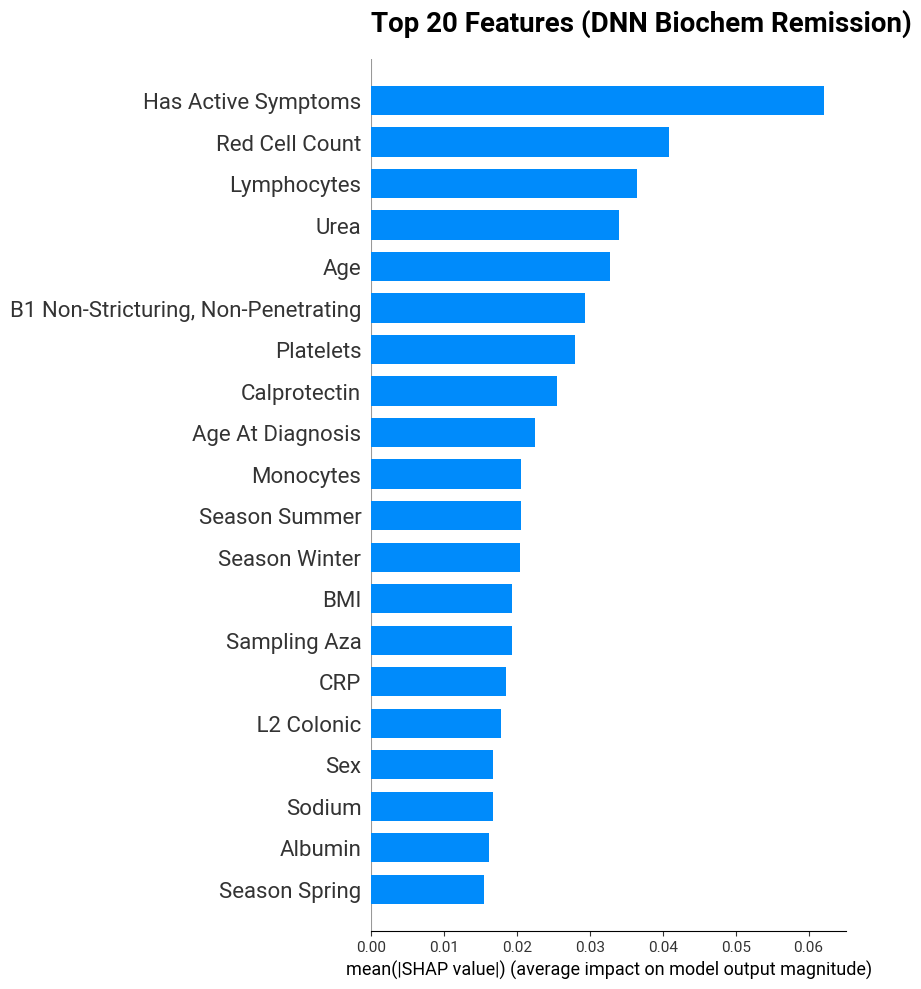

In [23]:
shap.summary_plot(
    shap_values_class_1,
    X_test,
    feature_names=X_test_clean_columns,
    show=False,
    cmap=cmap,
    plot_type="bar",
    max_display=20,
)

if run_biochem_remission:
    plt.title(
        "Top 20 Features (DNN Biochem Remission)",
        fontsize=20,
        pad=20,
        loc="left",
        fontweight="bold",
    )
else:
    plt.title(
        "Top 20 Features (DNN All IBD)",
        fontsize=20,
        pad=20,
        loc="left",
        fontweight="bold",
    )
plt.yticks(fontsize=16)

save_path = output_path / "plots" / "shap_dnn_feature_bar_plot.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

### Forceplots

In [24]:
# Revert scaled features to original values
X_test_reverted = X_test.copy()
X_test_reverted[numerical_features] = unified_scaler.inverse_transform(
    X_test[numerical_features]
).round(2)

In [25]:
# Create prediction groups based on true and predicted values
predictions_df = pd.DataFrame(
    {"true": y_test, "pred": y_classes.ravel()}, index=y_test.index
)

# Split into TP, TN, FP, FN groups
true_positives = predictions_df[
    (predictions_df["true"] == 1) & (predictions_df["pred"] == 1)
]
true_negatives = predictions_df[
    (predictions_df["true"] == 0) & (predictions_df["pred"] == 0)
]
false_positives = predictions_df[
    (predictions_df["true"] == 0) & (predictions_df["pred"] == 1)
]
false_negatives = predictions_df[
    (predictions_df["true"] == 1) & (predictions_df["pred"] == 0)
]


In [26]:
shap_values_df = pd.DataFrame(shap_values_class_1, index=y_test.index)

In [27]:
# Create dictionary of prediction groups and their data
MIN_NUMBER_OF_PLOTS = 5

prediction_groups = {
    "true_positive": (true_positives, MIN_NUMBER_OF_PLOTS),
    "true_negative": (true_negatives, MIN_NUMBER_OF_PLOTS),
    "false_positive": (false_positives, MIN_NUMBER_OF_PLOTS),
    "false_negative": (false_negatives, MIN_NUMBER_OF_PLOTS),
}

In [28]:
# Print summary statistics
print("\nPrediction Group Sizes:")
for group_name, (group_df, _) in prediction_groups.items():
    print(f"{group_name}: {len(group_df)} cases")


Prediction Group Sizes:
true_positive: 9 cases
true_negative: 36 cases
false_positive: 0 cases
false_negative: 3 cases


In [29]:
def generate_forceplot(shap_values, X_data, expected_value, save_path):
    """Generate and save SHAP force plot for a single prediction"""
    shap.force_plot(
        expected_value,
        shap_values,
        X_data,
        matplotlib=True,
        contribution_threshold=0.05,
        text_rotation=30,
        show=False,
    )
    plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.close()


# Generate force plots for each group
for group_name, (group_df, n_plots) in prediction_groups.items():
    if len(group_df) > 0:
        # Get data and SHAP values for this group
        X_group = X_test_reverted.loc[group_df.index].reset_index(drop=True)
        shap_values_group = shap_values_df.loc[group_df.index].to_numpy()

        # Generate plots
        n_plots = min(
            n_plots, len(group_df)
        )  # Ensure we don't exceed available samples
        for i in range(n_plots):
            save_path = output_path / "plots" / "forceplots" / f"{group_name}_{i}.png"
            generate_forceplot(
                shap_values_group[i],
                X_group.iloc[i],
                explainer.expected_value[0],
                save_path,
            )

In [30]:
# Export prediction dataframes for further analysis
for group_name, (group_df, _) in prediction_groups.items():
    if len(group_df) > 0:
        export_df = group_df.join(X_test_reverted)
        export_path = output_path / "evaluation" / f"{group_name}_predictions.csv"
        export_df.to_csv(export_path, index=True)

## Production Exports

In [31]:
today = datetime.datetime.now().strftime("%Y-%m-%d")

dump(unified_scaler, output_path / "exports" / f"scaler_{today}.pkl")
X_test.to_csv(output_path / "exports" / "X_test.csv", index=False)
model.save(output_path / "exports" / f"IFM-1_{today}.keras")
with open(output_path / "exports" / f"shap_explainer_{today}.pkl", "wb") as f:
    pickle.dump(explainer, f)